#   **Chicago Taxi Service Detailed Analysis**

* I am the sole contributor in the making of this notebook from scratch, no help was taken from the internet on this open-source dataset, or any second party.

In [35]:
# Importing Libraries

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns # data visualisation
import matplotlib.pyplot as plt # plot
from IPython.display import display, HTML, display_html
pd.set_option('display.max_columns', 1000)
pd.set_option('display.max_rows', 2000)
plt.rcParams['figure.figsize'] = [15.0, 5.0]

import warnings
warnings.filterwarnings('ignore')

#### The Original dataset contains over 92+ Million datapoints, but because of my system's processing constraints I am taking only 5 Million rows to do the analysis.

In [2]:
%%time
#Read the file
trip=pd.read_csv('C:/Users/GD/Downloads/trip.csv',nrows=5000000)
trip = trip.sort_values("trip_start_timestamp")

Wall time: 3min 49s


In [3]:
# Checking Missing Value percentage
trip.isna().sum()/len(trip) * 100

unique_key                 0.00000
taxi_id                    0.00042
trip_start_timestamp       0.00000
trip_end_timestamp         0.00462
trip_seconds               0.05874
trip_miles                 0.00066
pickup_census_tract       40.35640
dropoff_census_tract      40.94552
pickup_community_area     20.53012
dropoff_community_area    22.35768
fare                       0.00132
tips                       0.00132
tolls                     12.92788
extras                     0.00132
trip_total                 0.00132
payment_type               0.00000
company                   58.31352
pickup_latitude           20.52224
pickup_longitude          20.52224
pickup_location           20.52224
dropoff_latitude          22.15046
dropoff_longitude         22.15046
dropoff_location          22.15046
dtype: float64

In [4]:
# Handling Missing Values

trip.company.fillna('Other', inplace=True)
trip.tolls.fillna(0, inplace=True)
# trip.dropna(axis=0,how='all' ,subset=['fare'], inplace=True)
# trip.dropna(axis=0,how='all' ,subset=['taxi_id'], inplace=True)
# trip.dropna(axis=0,how='all' ,subset=['trip_miles'], inplace=True)
# trip.dropna(axis=0,how='all' ,subset=['trip_seconds'], inplace=True)

In [5]:
# Checking Start and End date of our data
trip.trip_start_timestamp.max(),trip.trip_start_timestamp.min()

('2018-09-22 22:30:00+00:00', '2013-04-05 13:00:00+00:00')

## Assumptions:
* Miles covered > 0
* Trip duration > 0
* Trip Fare > 0

In [6]:
# Applying Assumptions
trip = trip[(trip.trip_seconds > 0) & (trip.trip_miles > 0) & (trip.fare > 0)].reset_index()

## Handling Outliers

* There are alot of outliers in the dataset which will affect our analysis. So datapoints more that 3 times the standard deviation along the mean will be deleted

In [7]:
# Deleting values which are bigger than 3 times the standard deviation from mean, as they will hinder the analysis process

upper_sec = trip.trip_seconds.mean() + 3 * trip.trip_seconds.std()
trip = trip[(trip['trip_seconds'] < upper_sec)]

upper_miles = (trip.trip_miles.mean() + 3 * trip.trip_miles.std())
trip = trip[(trip['trip_miles'] < upper_miles)]

upper_fare = trip.fare.mean() + 3 * trip.fare.std()
trip = trip[(trip['fare'] < upper_fare)]

In [8]:
trip.shape
tri = trip.copy()

In [9]:
# Dropping columns we don't need right now
trip.drop(['pickup_census_tract','dropoff_census_tract','pickup_location','dropoff_location', 'pickup_latitude',
       'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude', 'payment_type', 'unique_key'], axis=1, inplace=True)

In [10]:
# Converting timestamp to datetime format

trip['trip_start_timestamp'] = pd.to_datetime(trip['trip_start_timestamp'])
trip['trip_end_timestamp'] = pd.to_datetime(trip['trip_end_timestamp'])

# Extracting information from timestamp

trip['trip_hour'] = trip['trip_start_timestamp'].dt.hour.astype('uint8')
trip['trip_day'] = trip['trip_start_timestamp'].dt.day.astype('uint8')
trip['trip_week'] = trip['trip_start_timestamp'].dt.week.astype('uint8')
trip['trip_weekday'] = trip['trip_start_timestamp'].dt.dayofweek.astype('uint8')
trip['trip_month'] = trip['trip_start_timestamp'].dt.month.astype('uint8')
trip['trip_quarter'] = trip['trip_start_timestamp'].dt.quarter.astype('uint8')
trip['trip_year'] = trip['trip_start_timestamp'].dt.year

In [11]:
trip.head()

,index,taxi_id,trip_start_timestamp,trip_end_timestamp,trip_seconds,trip_miles,pickup_community_area,dropoff_community_area,fare,tips,tolls,extras,trip_total,company,trip_hour,trip_day,trip_week,trip_weekday,trip_month,trip_quarter,trip_year
0,2276339,89e413368d4d8e1d00722208f1362492020757cd4672f3...,2013-05-03 12:00:00+00:00,2013-05-03 12:30:00+00:00,1740.0,11.0,NaN,NaN,25.65,0.0,0.0,0.0,25.65,Choice Taxi Association,12,3,18,4,5,2,2013
1,2894781,82140ed7b1b5465302a6f237ae0265664481112b7fed99...,2013-05-03 15:00:00+00:00,2013-05-03 15:00:00+00:00,660.0,24.0,24.0,32.0,8.85,0.0,0.0,0.0,8.85,Taxi Affiliation Services,15,3,18,4,5,2,2013
2,2898843,cdb5dabbf347707495209b5004193279f8b57994b7c456...,2013-05-03 20:30:00+00:00,2013-05-03 20:30:00+00:00,600.0,1.1,24.0,22.0,7.25,0.0,0.0,0.0,7.25,Northwest Management LLC,20,3,18,4,5,2,2013
3,2760157,da837ee33107a59b55ca160f2f85aee90cc3201a182632...,2013-05-03 21:00:00+00:00,2013-05-03 21:15:00+00:00,420.0,0.1,7.0,8.0,6.85,2.0,0.0,0.0,8.85,Blue Ribbon Taxi Association Inc.,21,3,18,4,5,2,2013
4,2531822,2b04a46ccd7beca299e9b773626fadfaba39bde4c63cb7...,2013-05-03 21:45:00+00:00,2013-05-03 22:00:00+00:00,360.0,0.1,32.0,28.0,8.25,0.0,0.0,0.0,8.25,Taxi Affiliation Services,21,3,18,4,5,2,2013


## Some Feature Engineering

In [12]:
# Calculating total monthly trips taken by a driver
group_pass = trip.groupby(['taxi_id','trip_year','trip_month']).size().to_frame('pickups_per_month').reset_index()
trip = pd.merge(trip,group_pass,on=['taxi_id','trip_year','trip_month'],how='left')

# Calculating total daily trips taken by a driver
group_pass = trip.groupby(['taxi_id','trip_year','trip_month','trip_day']).size().to_frame('pickups_per_day').reset_index()
trip = pd.merge(trip,group_pass,on=['taxi_id','trip_year','trip_month','trip_day'],how='left')

# Calculating total weekly trips taken by a driver
group_pass = trip.groupby(['taxi_id','trip_year','trip_month','trip_weekday']).size().to_frame('pickups_per_week').reset_index()
trip = pd.merge(trip,group_pass,on=['taxi_id','trip_year','trip_month','trip_weekday'],how='left')

# Calculating total quarterly trips taken by a driver
group_pass = trip.groupby(['taxi_id','trip_year','trip_quarter']).size().to_frame('pickups_per_quarter').reset_index()
trip = pd.merge(trip,group_pass,on=['taxi_id','trip_year','trip_quarter'],how='left')



# Calculating total monthly miles taken by a driver
group_pass = trip.groupby(['taxi_id','trip_year','trip_month']).trip_miles.sum().to_frame('miles_per_month').reset_index()
trip = pd.merge(trip,group_pass,on=['taxi_id','trip_year','trip_month'],how='left')

# Calculating total daily miles taken by a driver
group_pass = trip.groupby(['taxi_id','trip_year','trip_month','trip_day']).trip_miles.sum().to_frame('miles_per_day').reset_index()
trip = pd.merge(trip,group_pass,on=['taxi_id','trip_year','trip_month','trip_day'],how='left')

# Calculating total weekely miles taken by a driver
group_pass = trip.groupby(['taxi_id','trip_year','trip_month','trip_weekday']).trip_miles.sum().to_frame('miles_per_week').reset_index()
trip = pd.merge(trip,group_pass,on=['taxi_id','trip_year','trip_month','trip_weekday'],how='left')

# Calculating total quarterly miles taken by a driver
group_pass = trip.groupby(['taxi_id','trip_year','trip_quarter']).trip_miles.sum().to_frame('miles_per_quarter').reset_index()
trip = pd.merge(trip,group_pass,on=['taxi_id','trip_year','trip_quarter'],how='left')

In [13]:
# Calculating total hourly trips taken by the driver

group_pass = trip.groupby(['taxi_id','trip_year','trip_month','trip_day','trip_hour']).size().to_frame('pickups_per_hour').reset_index()
trip = pd.merge(trip,group_pass,on=['taxi_id','trip_year','trip_month','trip_day','trip_hour'],how='left')

# Calculating total hourly miles driven by the driver

group_pass = trip.groupby(['taxi_id','trip_year','trip_month','trip_day','trip_hour']).trip_miles.sum().to_frame('miles_per_hour').reset_index()
trip = pd.merge(trip,group_pass,on=['taxi_id','trip_year','trip_month','trip_day','trip_hour'],how='left')

In [14]:
trip.head(2)

,index,taxi_id,trip_start_timestamp,trip_end_timestamp,trip_seconds,trip_miles,pickup_community_area,dropoff_community_area,fare,tips,tolls,extras,trip_total,company,trip_hour,trip_day,trip_week,trip_weekday,trip_month,trip_quarter,trip_year,pickups_per_month,pickups_per_day,pickups_per_week,pickups_per_quarter,miles_per_month,miles_per_day,miles_per_week,miles_per_quarter,pickups_per_hour,miles_per_hour
0,2276339,89e413368d4d8e1d00722208f1362492020757cd4672f3...,2013-05-03 12:00:00+00:00,2013-05-03 12:30:00+00:00,1740.0,11.0,NaN,NaN,25.65,0.0,0.0,0.0,25.65,Choice Taxi Association,12,3,18,4,5,2,2013,2,1,1,2,11.1,11.0,11.0,11.1,1,11.0
1,2894781,82140ed7b1b5465302a6f237ae0265664481112b7fed99...,2013-05-03 15:00:00+00:00,2013-05-03 15:00:00+00:00,660.0,24.0,24.0,32.0,8.85,0.0,0.0,0.0,8.85,Taxi Affiliation Services,15,3,18,4,5,2,2013,2,1,1,2,32.0,24.0,24.0,32.0,1,24.0


In [22]:
# Deleting anomalies, since there is no way anyone can make more than 30 pickup in an hour
trip = trip.drop(trip[trip.pickups_per_hour > 30].index)
trip = trip.drop(trip[trip.miles_per_hour > 80].index)

# Hourly demand Graph

In [36]:
trip.trip_hour.value_counts()[trip.trip_hour.value_counts() > (trip.trip_hour.value_counts().mean() + 1 * trip.trip_hour.value_counts().std())]

18    296334
19    286063
17    272598
Name: trip_hour, dtype: int64

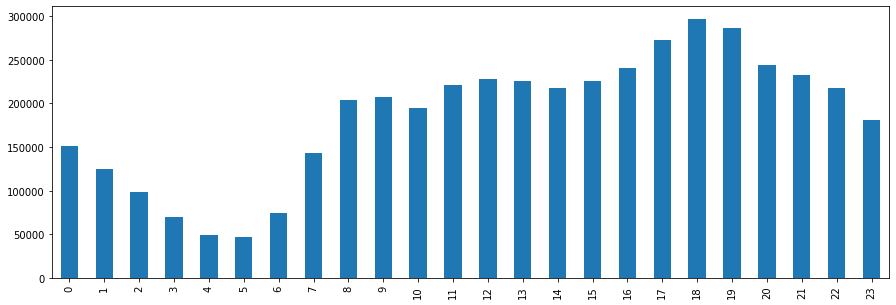

In [37]:
# plot for the number of trips in each hour across the day
trip.trip_hour.value_counts().sort_index().plot('bar')
plt.show()

# Inference 
* Low demand early in the Morning
* High demand in the Evening

### We can put incentives on Drivers operating between 17-19 hours because of high demand. Let's do some more calculations to find the incentive bracket

In [261]:
taxi_per_hour_stats = trip.groupby(['taxi_id','trip_year','trip_month','trip_day' ,'trip_hour']).agg({'taxi_id': ['count','nunique'], 'fare': 'sum', 'trip_seconds': 'sum', 'trip_miles': 'sum'})
taxi_per_hour_stats.columns = ['trips','unique_taxis' ,'fare', 'seconds', 'miles']
taxi_per_hour_stats.reset_index(inplace=True)
taxi_per_hour_stats.head()

,taxi_id,trip_year,trip_month,trip_day,trip_hour,trips,unique_taxis,fare,seconds,miles
0,001330b81e23412049f9c3eff5b6e972a91afe59c9aa36...,2014,1,11,21,1,1,7.25,600.0,1.2
1,001330b81e23412049f9c3eff5b6e972a91afe59c9aa36...,2014,1,25,1,1,1,7.05,360.0,1.8
2,001330b81e23412049f9c3eff5b6e972a91afe59c9aa36...,2014,1,27,17,1,1,4.45,120.0,0.6
3,001330b81e23412049f9c3eff5b6e972a91afe59c9aa36...,2014,4,6,23,1,1,4.05,120.0,0.4
4,001330b81e23412049f9c3eff5b6e972a91afe59c9aa36...,2014,6,29,13,1,1,24.25,1260.0,11.7


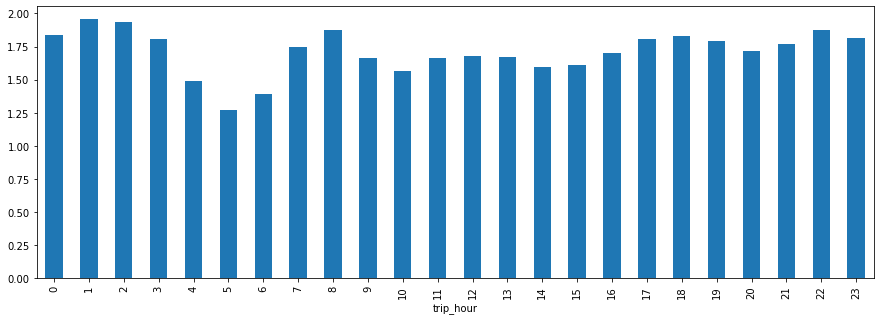

In [74]:
taxi_per_hour_stats.groupby('trip_hour')['trips'].mean().plot('bar')

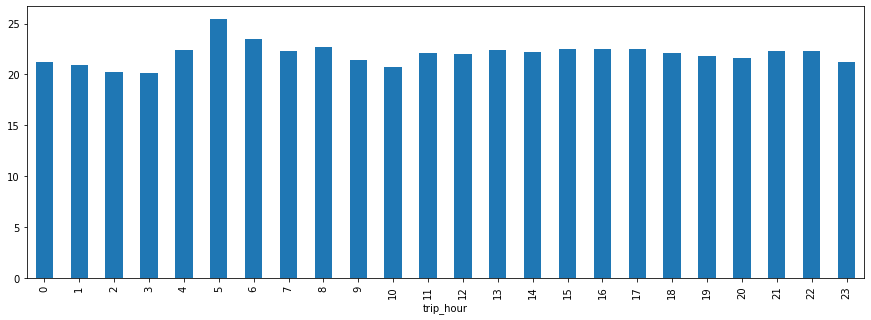

In [75]:
# Average fare per hour 
taxi_per_hour_stats.groupby('trip_hour')['fare'].mean().plot('bar')

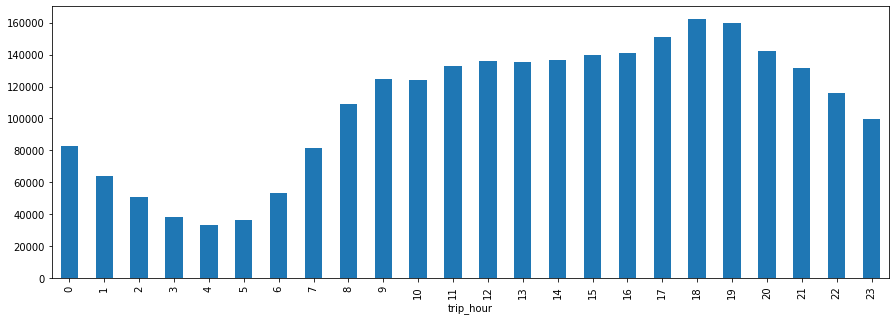

In [262]:
# IN Peak hours the number of taxis operating is also higher.
taxi_per_hour_stats.groupby('trip_hour')['unique_taxis'].sum().plot('bar')

In [76]:
# On average a taxi driver takes 2 trips/hour throughout the day and about 41 trips/day
taxi_per_hour_stats.groupby('trip_hour')['trips'].mean().mean(), taxi_per_hour_stats.groupby('trip_hour')['trips'].mean().sum()

(1.7106516148458644, 41.05563875630075)

In [77]:
# On peak hours (17-19), a driver takes an average of 2 trips
taxi_per_hour_stats.groupby('trip_hour')['trips'].mean()[taxi_per_hour_stats.groupby('trip_hour')['trips'].mean().index.isin([17, 18, 19])].mean()

1.8084574908659388

In [78]:
# On average a taxi driver earns 22$/hour throughout the day, and aroud 529$/day
taxi_per_hour_stats.groupby('trip_hour')['fare'].mean().mean(), taxi_per_hour_stats.groupby('trip_hour')['fare'].mean().sum()

(22.021440133554197, 528.5145632053009)

In [79]:
# On peak hours (17-19), a driver earns an average of 22$
taxi_per_hour_stats.groupby('trip_hour')['fare'].mean()[taxi_per_hour_stats.groupby('trip_hour')['fare'].mean().index.isin([17, 18, 19])].mean()

22.166651964362675

In [80]:
# normally a driver earns 13$/trip
taxi_per_hour_stats.groupby('trip_hour')['fare'].mean().mean()/taxi_per_hour_stats.groupby('trip_hour')['trips'].mean().mean()

12.873129714105117

In [81]:
# But on peak hours a driver earns only 12$/trip
taxi_per_hour_stats.groupby('trip_hour')['fare'].mean()[taxi_per_hour_stats.groupby('trip_hour')['fare'].mean().index.isin([17, 18, 19])].mean()/taxi_per_hour_stats.groupby('trip_hour')['trips'].mean()[taxi_per_hour_stats.groupby('trip_hour')['trips'].mean().index.isin([17, 18, 19])].mean()

12.25721482330706

In [82]:
# A driver drives around 7 miles/hour and about 164 miles in a day
taxi_per_hour_stats.groupby('trip_hour')['miles'].mean().mean(), taxi_per_hour_stats.groupby('trip_hour')['miles'].mean().sum()

(6.832480633284718, 163.97953519883325)

In [83]:
# A driver drives around 6-7 miles/hour in peak hours
taxi_per_hour_stats.groupby('trip_hour')['miles'].mean()[taxi_per_hour_stats.groupby('trip_hour')['miles'].mean().index.isin([17, 18, 19])].mean()

6.369281994279461

In [84]:
# 3.2$/miles normally
taxi_per_hour_stats.groupby('trip_hour')['fare'].mean().mean()/taxi_per_hour_stats.groupby('trip_hour')['miles'].mean().mean()

3.2230519653836733

In [85]:
# 3.5$/miles in peak hours
taxi_per_hour_stats.groupby('trip_hour')['fare'].mean()[taxi_per_hour_stats.groupby('trip_hour')['fare'].mean().index.isin([17, 18, 19])].mean()/taxi_per_hour_stats.groupby('trip_hour')['miles'].mean()[taxi_per_hour_stats.groupby('trip_hour')['miles'].mean().index.isin([17, 18, 19])].mean()

3.4802434535433573

A driver takes 2 trips per hour in peak hours, to qualify for incentives driver has to take atleast 3 trips per hour which means for peak hours 17,18,19 user should make atleast 10 trips to qualify for Incentives

* Asking drivers to do 10 or more than 10 rides between 17-19 i.e. at least 3 rides/hour in peak hours
* Since, the difference between the mean of peak and non-peak hours is 0.5\\$, the incentive would be that a driver will get 0.4\\$ bonus for each ride if the number of rides in the peak hours in greater than 10
* For eg. 
  1. if driver does 9 rides in peak hours (17-19), he will not be eligible for any bonus
  2. if driver does 10 rides in peak hours (17-19), he will get 0.4\\$ bonus
  3. if driver does 11 rides in peak hours (17-19), he will get 0.8\\$ bonus

# Monthly Demand Graph

In [86]:
# Setting the limit to 0.9 times the standard deviation from the mean to get the top performing months data

trip.trip_month.value_counts()[trip.trip_month.value_counts() > (trip.trip_month.value_counts().mean() + .9 * trip.trip_month.value_counts().std())]

8    859375
3    658179
4    653556
9    636063
Name: trip_month, dtype: int64

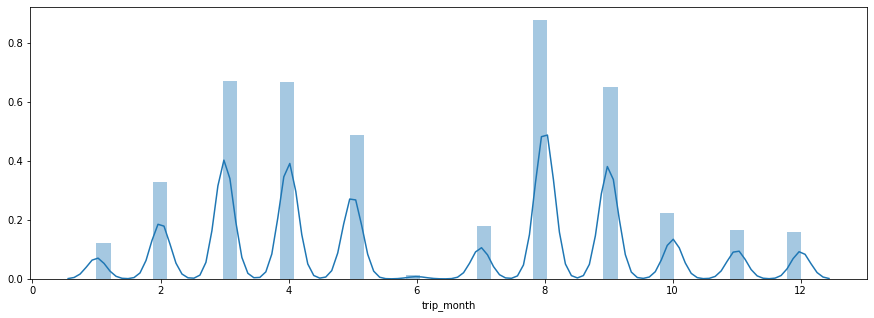

In [88]:
# We can see some months are quite active in the demand for pickups, we should focus on those
sns.distplot(trip.trip_month)


# We need Drivers to be fairly active during August, September, March, April

In [53]:
# Getting Insights!
taxi_per_month_stats = trip.groupby(['taxi_id','trip_year','trip_month']).agg({'taxi_id': 'count', 'fare': 'sum', 'trip_seconds': 'sum', 'trip_miles': 'sum'})
taxi_per_month_stats.columns = ['trips', 'fare', 'seconds', 'miles']
taxi_per_month_stats.reset_index(inplace=True)
taxi_per_month_stats.head()

,taxi_id,trip_year,trip_month,trips,fare,seconds,miles
0,001330b81e23412049f9c3eff5b6e972a91afe59c9aa36...,2014,1,3,18.75,1080.0,3.6
1,001330b81e23412049f9c3eff5b6e972a91afe59c9aa36...,2014,4,1,4.05,120.0,0.4
2,001330b81e23412049f9c3eff5b6e972a91afe59c9aa36...,2014,6,2,29.70,1500.0,12.7
3,001330b81e23412049f9c3eff5b6e972a91afe59c9aa36...,2014,7,17,254.25,16860.0,92.8
4,001330b81e23412049f9c3eff5b6e972a91afe59c9aa36...,2014,8,35,432.35,28080.0,150.0


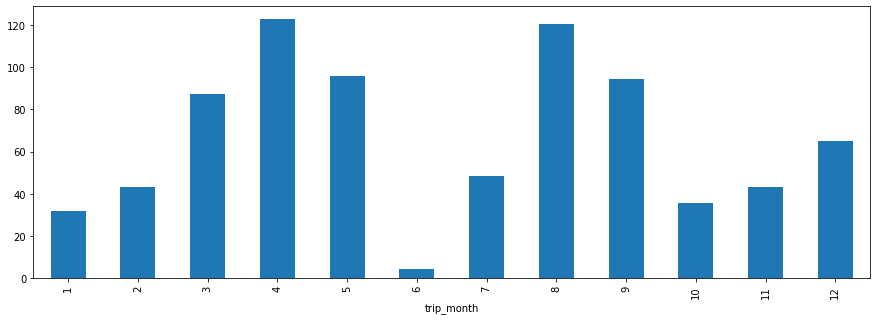

In [275]:
# average trips taken per month
taxi_per_month_stats.groupby('trip_month')['trips'].mean().plot('bar')

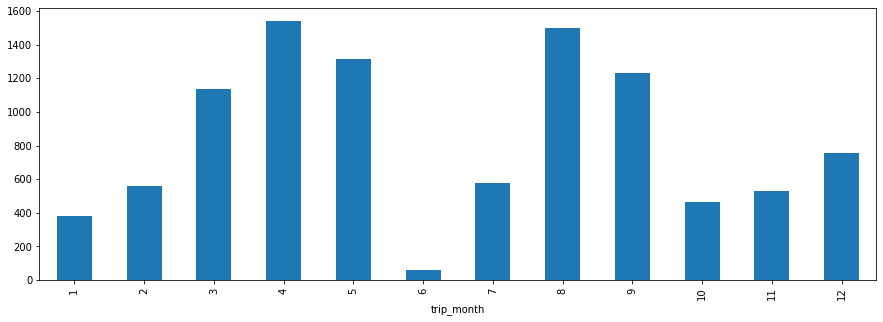

In [57]:
# Monthly average fare of each month.
# April and August have high average fares

taxi_per_month_stats.groupby('trip_month')['fare'].mean().plot('bar')

In [89]:
# On average a taxi driver takes 66 trips throughout the month and about 41 trips/year
taxi_per_month_stats.groupby('trip_month')['trips'].mean().mean(), taxi_per_month_stats.groupby('trip_month')['trips'].mean().sum()

(66.07664674493627, 792.9197609392352)

In [90]:
# On peak months (3,4,8,9) a driver takes an average of 106 trips
taxi_per_month_stats.groupby('trip_month')['trips'].mean()[taxi_per_month_stats.groupby('trip_month')['trips'].mean().index.isin([3,4,8,9])].mean()

106.24409775708956

In [93]:
# On average a taxi driver earns 838$/month throughout the day, and aroud 10,058$/year
taxi_per_month_stats.groupby('trip_month')['fare'].mean().mean(), taxi_per_month_stats.groupby('trip_month')['fare'].mean().sum()

(838.1515436559761, 10057.818523871712)

In [94]:
# On peak hours (3.4,8,9), a driver earns an average of 1352$
taxi_per_month_stats.groupby('trip_month')['fare'].mean()[taxi_per_month_stats.groupby('trip_month')['fare'].mean().index.isin([3,4,8,9])].mean()

1352.0983034414994

In [95]:
# normally a driver earns 13$/trip in a month
taxi_per_month_stats.groupby('trip_month')['fare'].mean().mean()/taxi_per_month_stats.groupby('trip_month')['trips'].mean().mean()

12.684535080772802

In [96]:
# But on peak months a driver earns only 13$/trip
taxi_per_month_stats.groupby('trip_month')['fare'].mean()[taxi_per_month_stats.groupby('trip_month')['fare'].mean().index.isin([3,4,8,9])].mean()/taxi_per_month_stats.groupby('trip_month')['trips'].mean()[taxi_per_month_stats.groupby('trip_month')['trips'].mean().index.isin([3,4,8,9])].mean()

12.726338045929475

In [97]:
# A driver drives around 259 miles/month and about 3107 miles in a year
taxi_per_month_stats.groupby('trip_month')['miles'].mean().mean(), taxi_per_month_stats.groupby('trip_month')['miles'].mean().sum()

(258.8849676550279, 3106.619611860335)

In [98]:
# A driver drives around 410 miles/month in peak months
taxi_per_month_stats.groupby('trip_month')['miles'].mean()[taxi_per_month_stats.groupby('trip_month')['miles'].mean().index.isin([3,4,8,9])].mean()

409.7135110929862

In [99]:
# 3.24$/miles normally
taxi_per_month_stats.groupby('trip_month')['fare'].mean().mean()/taxi_per_month_stats.groupby('trip_month')['miles'].mean().mean()

3.2375442701363744

In [101]:
# 3.3$/miles in peak hours
taxi_per_month_stats.groupby('trip_month')['fare'].mean()[taxi_per_month_stats.groupby('trip_month')['fare'].mean().index.isin([3,4,8,9])].mean()/taxi_per_month_stats.groupby('trip_month')['miles'].mean()[taxi_per_month_stats.groupby('trip_month')['miles'].mean().index.isin([3,4,8,9])].mean()

3.300106700983642

In peak months a driver driver 410 miles on average earning 3$ per miles

## Incentive:

* If Driver drives more than 500+ miles in peak months bonus = 150\\$
* 600+ miles, bonus = 350\\$ 
*

In [160]:
# Segmenting users on basis of Fare to Miles Ratio
# users travelling less miles but paying high fares are Top Priority users and so on

trip['extrafare_by_miles_ratio'] = round(trip.trip_total / trip.trip_miles)
trip['fare_by_miles_ratio'] = trip.fare / trip.trip_miles
def status(x):
    a =''
    if(x < 2):
        a='Low'
    elif((x>=2) and (x < 8)):
        a='Medium'
    elif(x>=8):
        a='High'
    else:
        a='Others'
    return a

trip['status'] = trip.extrafare_by_miles_ratio.apply(status)

Wall time: 1min 10s


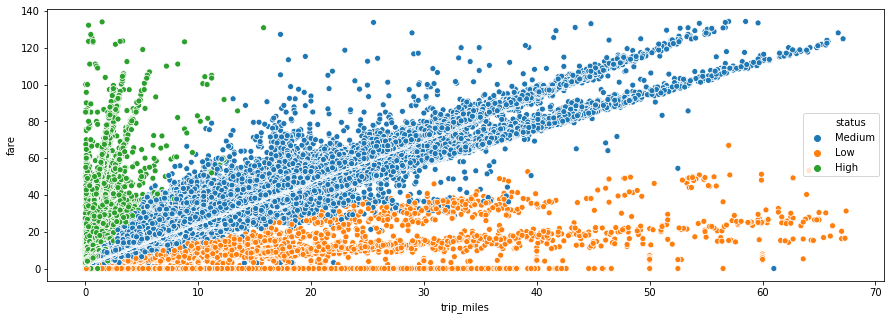

In [152]:
%%time
sns.scatterplot(trip.trip_miles, trip.fare, hue= trip.status)

### Here we divided users into 3 different categories

# Segmentation: 

 * High fare less miles (HIGH)
 * High miles less fare (LOW)
 * Linear relationship   (Medium)

# Let's check which communities host these users

# Checking Pickup Communities

In [240]:
# Trying to find Rich Communities
rich_community = pd.crosstab(trip.pickup_community_area, trip.status).reset_index()
rich_community['total'] = rich_community.High + rich_community.Low + rich_community.Medium
rich_community.High = rich_community.High / rich_community.total
rich_community.Low = rich_community.Low / rich_community.total
rich_community.Medium = rich_community.Medium / rich_community.total

In [241]:
rich_community.High[rich_community.High > (rich_community.High.mean() + 1 * rich_community.High.std())]

5     0.216347
7     0.347722
27    0.293395
31    0.373353
48    0.290891
57    0.220630
58    0.234273
63    0.238255
64    0.223602
Name: High, dtype: float64

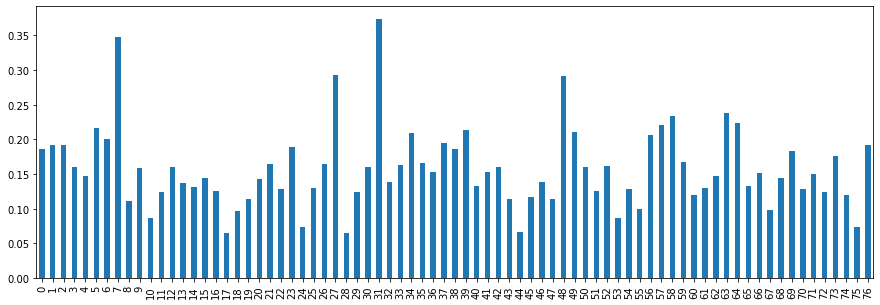

In [242]:
rich_community.High.plot('bar')

# Community:
* Communities 5,7,27,31,48,57,58,63,64 have high Fare to miles ratio, so we can assign them Priority Rides
* More than 21% users pay high Fares while covering less miles in these communities

In [ ]:
# Community insights!

commu = trip.groupby('pickup_community_area').Avg_pickup_time_per_community.mean().to_frame('Avg_time_to_pickup').reset_index()

commu_pick = trip.groupby('pickup_community_area').size().to_frame('total_pickups').reset_index()
comm_miles = trip.groupby('pickup_community_area').trip_miles.mean().to_frame('Avg_miles_covered').reset_index()
comm_fare = trip.groupby('pickup_community_area').fare.mean().to_frame('Avg_fare').reset_index()
comm_extra_mean = trip.groupby('pickup_community_area').extras.mean().to_frame('extrafare_mean').reset_index()
comm_total_toll = trip.groupby('pickup_community_area').tolls.sum().to_frame('total_toll').reset_index()
comm_tfare_mean = trip.groupby('pickup_community_area').trip_total.mean().to_frame('Avg_totalfare').reset_index()

commu = commu.merge(commu_pick ,on='pickup_community_area')
commu = commu.merge(comm_miles ,on='pickup_community_area')
commu = commu.merge(comm_fare ,on='pickup_community_area')
commu = commu.merge(comm_extra_mean ,on='pickup_community_area')
commu = commu.merge(comm_total_toll ,on='pickup_community_area')
commu = commu.merge(comm_tfare_mean ,on='pickup_community_area')
# commu = commu.merge(commu_pick ,on='pickup_community_area')

commu['fare_by_miles_ratio'] = commu.Avg_miles_covered / commu.Avg_totalfare

# commu.sort_values('fare_by_miles_ratio', ascending=True)

In [211]:
commu.sort_values('fare_by_miles_ratio', ascending=True)

,pickup_community_area,Avg_time_to_pickup,total_pickups,Avg_miles_covered,Avg_fare,extrafare_mean,total_toll,Avg_totalfare,fare_by_miles_ratio
74,75.0,26070.722892,84,9.570357,26.095833,90.804167,0.00,117.480595,0.081463
27,28.0,8.803276,321512,2.585561,10.161174,0.477641,282.26,11.593358,0.223021
7,8.0,2.309054,1227244,2.739499,10.395957,0.613688,697.66,12.077292,0.226831
31,32.0,3.314881,854457,2.822556,10.641202,0.513710,405.98,12.400070,0.227624
6,7.0,14.975004,189035,2.849682,10.604621,0.596510,56.50,12.062207,0.236249
23,24.0,23.152460,121928,2.948141,10.790412,0.525183,66.19,12.037486,0.244913
58,59.0,2412.442997,922,2.789295,9.954469,0.578091,0.00,11.335304,0.246071
32,33.0,31.966732,87832,3.884505,13.441560,0.729920,65.30,15.634695,0.248454
5,6.0,11.686389,240165,3.381710,11.788287,0.541160,335.82,13.264972,0.254935
21,22.0,53.574254,41709,3.394881,11.697628,0.565260,7.20,12.981148,0.261524


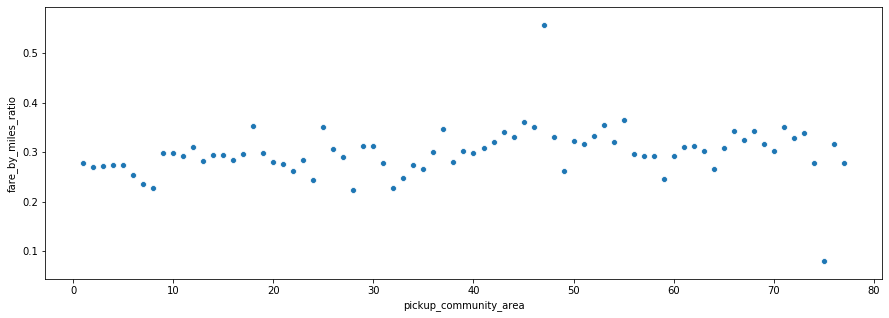

In [121]:
# Ratio of Fare by Total miles covered
sns.scatterplot(commu.pickup_community_area, commu.fare_by_miles_ratio)

## Users of Community 75, 28, 8, 32, 7, 24, 59, 33, 6 pay more per mile than others. So we can put these Communities to Priority service

# Checking Pickup time 

In [277]:
# Calculating time taken(in minutes) to get a new ride for a driver
trip['time_since_last_pickup'] = trip.groupby('taxi_id')['trip_start_timestamp'].diff()
trip['time_since_last_pickup'] = (trip['time_since_last_pickup'].dt.total_seconds()) / 60

In [279]:
# time took to get a new pickup for a driver
trip.time_since_last_pickup.value_counts().sort_index().cumsum() / trip.shape[0]

0.0          0.071475
15.0         0.379682
30.0         0.569381
45.0         0.662922
60.0         0.716790
               ...   
1677540.0    0.998516
1806510.0    0.998517
1811265.0    0.998517
1913430.0    0.998517
2111070.0    0.998517
Name: time_since_last_pickup, Length: 15045, dtype: float64

# Almost 57% Drivers got a new pickup within 30 minutes

# Checking Top Community Contributions

In [193]:
# Checking the cumulative sum of community contributions

pd.DataFrame(trip.pickup_community_area.value_counts().cumsum() / len(trip))

,pickup_community_area
8.0,0.275682
32.0,0.467624
28.0,0.539847
76.0,0.595407
6.0,0.649357
7.0,0.691821
24.0,0.719210
33.0,0.738940
56.0,0.752497
3.0,0.765672


## Only 21% of the communities contribute to around 80% of the pickups and dropouts

16 communities out of 77 total communities

In [339]:
len(trip.dropoff_community_area.value_counts())

77

## Checking the Extra payments made during the trip

In [221]:
trip.head()

,index,taxi_id,trip_start_timestamp,trip_end_timestamp,trip_seconds,trip_miles,pickup_community_area,dropoff_community_area,fare,tips,tolls,extras,trip_total,company,trip_hour,trip_day,trip_week,trip_weekday,trip_month,trip_quarter,trip_year,pickups_per_month,pickups_per_day,pickups_per_week,pickups_per_quarter,miles_per_month,miles_per_day,miles_per_week,miles_per_quarter,pickups_per_hour,miles_per_hour,pickup_diff_commumity,Avg_pickup_time_per_community,fare_by_miles_ratio,status,extrafare_by_miles_ratio,totalfare
0,2276339,89e413368d4d8e1d00722208f1362492020757cd4672f3...,2013-05-03 12:00:00+00:00,2013-05-03 12:30:00+00:00,1740.0,11.0,NaN,NaN,25.65,0.0,0.0,0.0,25.65,Choice Taxi Association,12,3,18,4,5,2,2013,2,1,1,2,11.1,11.0,11.0,11.1,1,11.0,NaN,NaN,2.331818,Medium,2.0,25.65
1,2894781,82140ed7b1b5465302a6f237ae0265664481112b7fed99...,2013-05-03 15:00:00+00:00,2013-05-03 15:00:00+00:00,660.0,24.0,24.0,32.0,8.85,0.0,0.0,0.0,8.85,Taxi Affiliation Services,15,3,18,4,5,2,2013,2,1,1,2,32.0,24.0,24.0,32.0,1,24.0,NaN,23.152460,0.368750,Low,0.0,8.85
2,2898843,cdb5dabbf347707495209b5004193279f8b57994b7c456...,2013-05-03 20:30:00+00:00,2013-05-03 20:30:00+00:00,600.0,1.1,24.0,22.0,7.25,0.0,0.0,0.0,7.25,Northwest Management LLC,20,3,18,4,5,2,2013,1,1,1,1,1.1,1.1,1.1,1.1,1,1.1,330.0,23.152460,6.590909,Medium,7.0,7.25
3,2760157,da837ee33107a59b55ca160f2f85aee90cc3201a182632...,2013-05-03 21:00:00+00:00,2013-05-03 21:15:00+00:00,420.0,0.1,7.0,8.0,6.85,2.0,0.0,0.0,8.85,Blue Ribbon Taxi Association Inc.,21,3,18,4,5,2,2013,1,1,1,1,0.1,0.1,0.1,0.1,1,0.1,NaN,14.975004,68.500000,High,88.0,6.85
4,2531822,2b04a46ccd7beca299e9b773626fadfaba39bde4c63cb7...,2013-05-03 21:45:00+00:00,2013-05-03 22:00:00+00:00,360.0,0.1,32.0,28.0,8.25,0.0,0.0,0.0,8.25,Taxi Affiliation Services,21,3,18,4,5,2,2013,1,1,1,1,0.1,0.1,0.1,0.1,1,0.1,NaN,3.314881,82.500000,High,82.0,8.25


In [234]:
# Only keeping the extra fare and the fare in the total fare column
trip['totalfare'] = trip.trip_total - trip.tips - trip.tolls

# Calculating the percentage of extra charges on fare of the trip

trip['perc_extra_fare'] = (((trip.totalfare - trip.fare) / trip.fare) * 100)

In [ ]:
# trip['pickup_diff_commumity'] = trip.groupby('pickup_community_area')['trip_start_timestamp'].diff().dt.total_seconds() / 60
# trip['Avg_pickup_time_per_community'] = trip.pickup_community_area.map(trip.groupby('pickup_community_area').pickup_diff_commumity.mean())

In [230]:
trip.groupby('pickup_community_area').perc_extra_fare.mean()

pickup_community_area
1.0      3.709365
2.0      3.296944
3.0      3.861070
4.0      3.452456
5.0      4.637933
6.0      5.733825
7.0      7.320624
8.0      7.544280
9.0      5.184137
10.0     7.478556
11.0     3.471061
12.0     3.346141
13.0     3.361543
14.0     3.801056
15.0     4.050769
16.0     3.330526
17.0     3.798251
18.0     1.740754
19.0     3.308475
20.0     2.253663
21.0     3.630128
22.0     5.736561
23.0     4.092432
24.0     6.161962
25.0     2.611017
26.0     3.814625
27.0     7.593545
28.0     7.121160
29.0     6.339841
30.0     3.410366
31.0     4.339382
32.0     6.210865
33.0     7.101246
34.0     8.256195
35.0     3.347247
36.0     3.870134
37.0     2.017649
38.0     3.317592
39.0     2.263799
40.0     2.605750
41.0     4.302088
42.0     3.014278
43.0     3.125548
44.0     1.124903
45.0     1.072413
46.0     2.620094
47.0     1.032961
48.0     1.112403
49.0     4.129612
50.0     1.719516
51.0     1.581871
52.0     1.895435
53.0     1.917786
54.0     1.365852
55.0  

In [226]:
# Dropping anomalies
trip = trip.drop(trip[trip.extras == 7591.55].index)

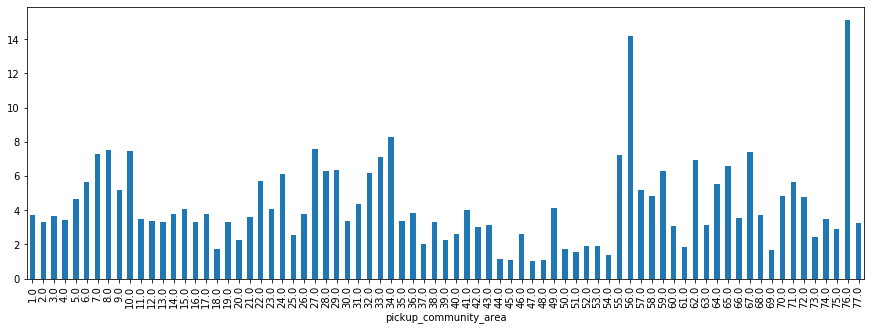

In [239]:
# Here we can see the communities which pay huge amount of extra fares

trip.groupby('pickup_community_area').perc_extra_fare.mean().plot('bar')

In [264]:
# Setting the limit to 1 times the standard deviation over mean to get the top performers. 

trip.groupby('pickup_community_area').perc_extra_fare.mean()[ trip.groupby('pickup_community_area').perc_extra_fare.mean() > (trip.groupby('pickup_community_area').perc_extra_fare.mean().mean() + 1 * trip.groupby('pickup_community_area').perc_extra_fare.mean().std())]

pickup_community_area
7.0      7.286642
8.0      7.505702
10.0     7.478556
27.0     7.589553
33.0     7.096985
34.0     8.255167
55.0     7.220503
56.0    14.163160
62.0     6.920235
67.0     7.425559
76.0    15.139012
Name: perc_extra_fare, dtype: float64

# As we can see the communities 56 and 76 pay considerable amount of Extra fare.

14-15% over the fare of the trip

In [274]:
# lets see which taxi company got the highest extra fare

trip.groupby(['company'])['perc_extra_fare'].mean().to_frame('perc_extra_fare').reset_index().sort_values('perc_extra_fare', ascending=False)

,company,perc_extra_fare
46,3669 - 85800 Jordan Taxi Inc,20.747807
78,5997 - AW Services Inc.,18.575624
1,0118 - Godfrey S.Awir,16.436211
77,5997 - 65283 AW Services Inc.,16.422621
36,3385 - 23210 Eman Cab,12.323042
116,Taxi Affiliation Service Yellow,11.849883
14,2241 - 44667 Manuel Alonso,11.661015
0,0118 - 42111 Godfrey S.Awir,11.557521
89,Blue Diamond,11.518438
49,4053 - 40193 Adwar H. Nikola,10.898812


Jordan Taxi received the highest amount of extra fare in percentage

# Conclusion:

* Some communities play a vital role in the entire process, as we saw 21% of communities contribute to over 80% of the traffic.

* So, we should focus on these communities with high priority.
* There are some communities which pay a lot per mile, which will result in higher profits, we can focus and prioritize on them too.

* Community Riders were segmented on the basis of high extra fare per mile and high fare per mile basis.

### Given more time we could utilize the location data like longitude and latitude in our analysis to generate some insights.